 PROBLEM - https://www.kaggle.com/gpiosenka/100-bird-species?select=train#

 STEPS TO GET FILES FROM KAGGLE - https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e#:~:text=On%20Google%20Drive%2C%20create%20a,json%20file.&text=Next%2C%20open%20a%20Colab%20notebook,Drive%20onto%20Colab's%20file%20system.

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.5 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 189 kB 23.2 MB/s 
     |████████████████████████████████| 1.2 MB 21.9 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 51 kB 303 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
import pathlib

In [4]:
!cp '/content/gdrive/MyDrive/Kaggle Json/kaggle.json' '/content'  
# TO copy kaggle json to current directory  

In [5]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [6]:
!kaggle datasets download -d gpiosenka/100-bird-species

#api command

100% 1.17G/1.17G [00:07<00:00, 171MB/s]
100% 1.17G/1.17G [00:07<00:00, 159MB/s]


In [7]:
zip_ref = zipfile.ZipFile('100-bird-species.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/images') #Extracts the files into the /tmp folder
zip_ref.close()

In [8]:
os.listdir('/images')

['test',
 'class_dict.csv',
 'images to test',
 'birds.csv',
 'train',
 'EfficientNetB3-birds-98.40.h5',
 'valid']

In [9]:
len(os.listdir('/images/train'))

325

In [ ]:
os.listdir('/images/train')  
# will give list of all 325 bird species folders. Each folder has 120+ images of that bird species.

In [11]:
path = '/images/train'

In [12]:
fns = get_image_files(path)
fns
#Our folder has image files

(#47332) [Path('/images/train/BLACK SKIMMER/117.jpg'),Path('/images/train/BLACK SKIMMER/007.jpg'),Path('/images/train/BLACK SKIMMER/020.jpg'),Path('/images/train/BLACK SKIMMER/077.jpg'),Path('/images/train/BLACK SKIMMER/065.jpg'),Path('/images/train/BLACK SKIMMER/084.jpg'),Path('/images/train/BLACK SKIMMER/048.jpg'),Path('/images/train/BLACK SKIMMER/061.jpg'),Path('/images/train/BLACK SKIMMER/088.jpg'),Path('/images/train/BLACK SKIMMER/060.jpg')...]

In [13]:
#Often when we download files from the internet, there are a few that are corrupt. Let's check:

failed = verify_images(fns)
failed

(#0) []

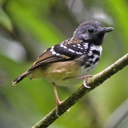

In [13]:
im = Image.open('/images/train/ANTBIRD/128.jpg')
im.to_thumb(128,128)

In [ ]:
?? DataBlock()
# to read function description

In [14]:
birds = DataBlock(
    blocks= (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

# creating Data Block

In [15]:
dls = birds.dataloaders(path)

#Creating Dataloaders
#When you loop through a DataLoader fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. 

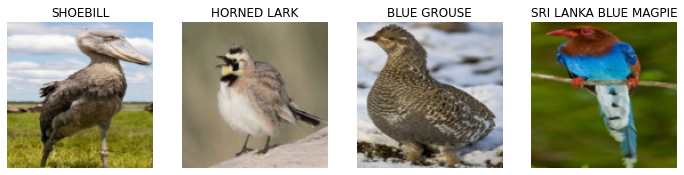

In [16]:
dls.train.show_batch(max_n=4, nrows= 1)

#We can take a look at a few of those items by calling the show_batch method on a DataLoader

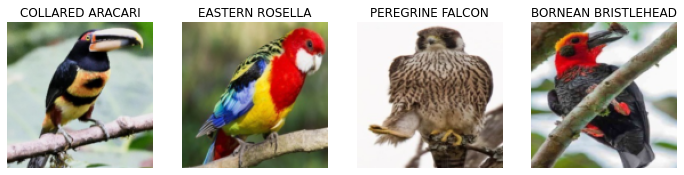

In [18]:
dls.valid.show_batch(max_n=4, nrows =1)

# Cropping to make square

- By default Resize crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them

- All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are

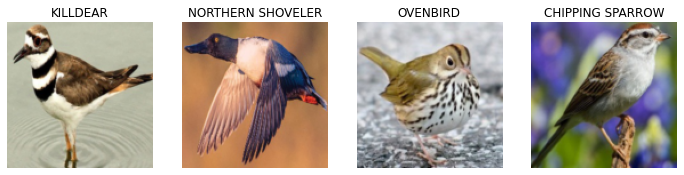

In [19]:
birds = birds.new(item_tfms= Resize(128, ResizeMethod.Squish))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n= 4, nrows =1)

# Results after SQUISHING images

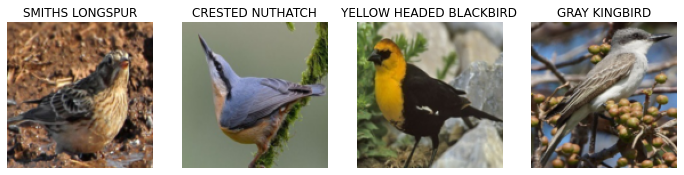

In [20]:
birds = birds.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n= 4, nrows=1)

# Padding with 'zeros' will introduce black borders 

- Another way (data augmentation) is to randomly select a part of the image and on each epoch take different parts. This way each image will have certain features of the original image and it will help model to understand that all the features belong to the same bird.  

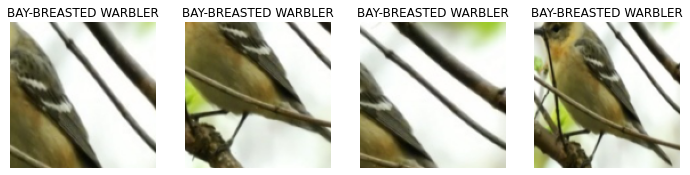

In [21]:
birds = birds.new(item_tfms = RandomResizedCrop(128, min_scale=0.3))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=4, nrows = 1, unique= True)

# Resize id replaced with RandomResizedCrop
# min_scale = how much of image minimum will be selected each time
# unique = True - to have repeated versions of the same image

### Data Augmentation

- Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. 
- Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.
- Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms.

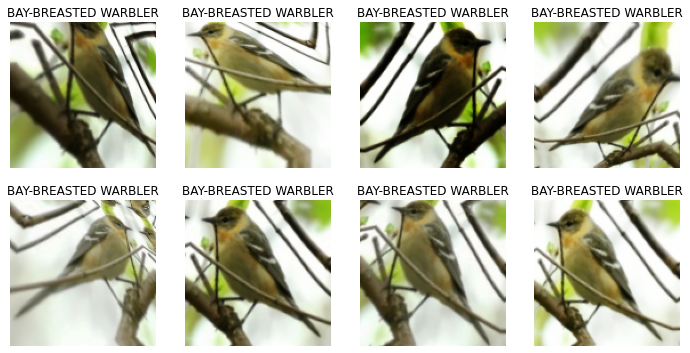

In [18]:
birds = birds.new(item_tfms = Resize(128), batch_tfms = aug_transforms(mult=2))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique= True)

### Training the model

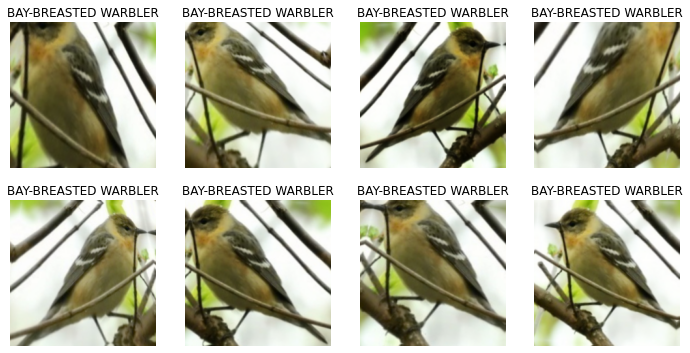

In [19]:
birds = birds.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms = aug_transforms())
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [20]:
# Creating Learner

learn= cnn_learner(dls, resnet18, metrics =error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.863171,0.857643,0.218149,06:32


epoch,train_loss,valid_loss,error_rate,time
0,0.920061,0.442758,0.111240,08:46
1,0.599817,0.321011,0.081132,08:46


- What is a metric? A metric is a function that measures the quality of the model's predictions using the validation set, and will be printed at the end of each epoch. In this case, we're using error_rate, which is a function provided by fastai that does just what it says: tells you what percentage of images in the validation set are being classified incorrectly. Another common metric for classification is accuracy (which is just 1.0 - error_rate)

- resnet18 - means architecture has 18 layers (pre trained model)

- When using a pretrained model, cnn_learner will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the head.

- fine_tune(4) - number of epochs. Fine-tuning: A transfer learning technique where the parameters of a pretrained model are updated by training for additional epochs using a different task to that used for pretraining.

- **The head of a model is the part that is newly added to be specific to the new dataset. An epoch is one complete pass through the dataset**

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)   - CRASHES SO NOT RUNNING
# interp.plot_confusion_matrix()  
# I will not plot confusion matrix as there a lot of bird classes

- plot_top_losses shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: **prediction, actual (target label), loss, and probability**. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction

In [ ]:
interp.plot_top_losses(5, nrows=1)

NameError: ignored

- fastai includes a handy **GUI** for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

### Turning Your Model into an Online Application


- export method - along with architecture and parameters, this method even saves the definition of how to create your DataLoaders. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set DataLoader for inference by default, so your data augmentation will not be applied, which is generally what you want.

- When you call export, fastai will save a file called "export.pkl":

In [21]:
learn.export()

In [22]:
os.listdir()

['.config',
 'drive',
 'gdrive',
 'export.pkl',
 '100-bird-species.zip',
 'kaggle.json',
 'sample_data']

In [23]:
path= Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [27]:
# SAVING PICKLE FILE IN COLAB FOR BACKUP

import pickle

with open('birdClassification_model_11Dec', 'wb') as f:
  pickle.dump(path/'export.pkl', f)

- When we use a model for getting predictions, instead of training, we call it inference. To create our inference learner from the exported file, we use load_learner (in this case, this isn't really necessary, since we already have a working Learner in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [25]:
learn_inf.predict('/images/train/ANTBIRD/128.jpg')

('ANTBIRD',
 TensorBase(13),
 TensorBase([4.3315e-09, 9.5943e-07, 8.8231e-09, 2.5787e-07, 3.7178e-06, 7.8431e-07, 7.8551e-09, 4.8924e-04, 5.0494e-05, 1.4301e-06, 1.1774e-05, 1.8145e-06, 2.3582e-06, 8.0096e-01, 3.0642e-05, 1.2629e-08,
         2.9128e-08, 3.3089e-08, 2.8401e-06, 5.1037e-05, 2.0788e-05, 2.0539e-03, 4.9358e-07, 3.1466e-07, 7.5478e-07, 7.8196e-07, 1.1979e-04, 3.4791e-03, 1.7568e-06, 8.0414e-05, 2.0085e-06, 1.0701e-03,
         9.5814e-08, 1.6706e-04, 5.9462e-04, 3.6141e-07, 1.3116e-07, 2.9695e-08, 3.6922e-08, 4.5895e-05, 3.3534e-02, 1.0884e-07, 6.8367e-06, 4.4035e-09, 6.8722e-04, 2.0539e-03, 6.5346e-04, 7.1427e-07,
         6.4646e-06, 2.5734e-07, 1.3286e-07, 4.4127e-04, 2.6388e-06, 5.2534e-06, 1.7057e-06, 7.0837e-09, 1.0217e-03, 4.7512e-08, 2.0503e-05, 1.7578e-08, 3.1691e-05, 1.4177e-07, 2.5020e-08, 2.5479e-06,
         1.7738e-07, 1.3656e-08, 1.0264e-05, 6.0789e-07, 6.1271e-06, 2.1947e-06, 3.3561e-08, 1.6342e-08, 3.1537e-06, 2.6084e-03, 1.1508e-04, 9.8204e-07, 1.2543e-05

In [26]:
learn_inf.dls.vocab
# Lists all the classes 

['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALD IBIS', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BANDED BROADBILL', 'BANDED PITA', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BEARDED BELLBIRD', 'BEARDED REEDLING', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK & YELLOW bROADBILL', 'BLACK BAZA', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK TAIL CRAKE', 'BLACK THROATED BUSHTIT', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLONDE CRESTED WOODPECKER', 'BLUE COAU', 'BLUE GROUSE', 'BLUE HERON', 'BLUE THROATED TOUCANET', 'BOBOLINK', 'BO

## NOTEBOOK APP FROM MODEL

- using IPython Widgets and Voila

In [28]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [29]:
img= PILImage.create(btn_upload.data[-1])

In [30]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: 
  display(img.to_thumb(128,128))

out_pl

Output()

Then we can get our predictions:

In [31]:
pred, pred_idx, probs = learn_inf.predict(img)

In [32]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: CROW; Probability: 0.7816')

We'll need a button to do the classification. It looks exactly like the upload button:

In [33]:
btn_run = widgets.Button(description= 'Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a click event handler; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above

In [34]:
def on_click_classify(change):
  img= PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl:
    display(img.to_thumb(128,128))
  pred, pred_idx, probs = learn.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

# You can test the button now by pressing it, and you should see the image and predictions update automatically!

#### We can now put them all in a vertical box (VBox) to complete our GUI:

In [35]:
#Putting back btn_upload to a widget for next cell

btn_upload = widgets.FileUpload()

In [37]:
VBox([widgets.Label('Select your bird !!!'),
     btn_upload, btn_run, out_pl, lbl_pred])